# CENG 483 THE 2

**Name: Furkan Numanoglu**

**Student ID: 2448710**


In [13]:
# You should use "images" folder on same directory with this code. I implement it in this way.


# Import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import time
import glob

#calculate the energy levels of pixels in grayscale
def calculateWithGray(image, w_d):
    shape_0, shape_1 = image.shape[0], image.shape[1]
    pixel_energies = np.zeros((shape_0, shape_1))  
    half = w_d // 2 
    border = w_d - 1  
    
    for i in range(border, shape_0 - border):
        for j in range(border, shape_1 - border):
            base_window = image[i - half:i + half+1, j - half:j + half+1]
            windows = [
                image[i:i + w_d, j:j + w_d],  #right top
                image[i:i + w_d, j - half:j + half+1],  #right
                image[i:i + w_d, j - half-1:j + half],  #right bottom
                image[i - half:i + half+1, j:j + w_d],  #top
                image[i - half:i + half+1, j - half-1:j + half],  #bottom
                image[i - half-1:i + half, j:j + w_d],  #left top
                image[i - half-1:i + half, j - half:j + half+1],  #left
                image[i - half-1:i + half, j - half-1:j + half]  #left bottom
            ]
            # sum of squared differences
            sum_squares = np.sum((base_window - np.array(windows)) ** 2, axis=(1, 2))
            pixel_energies[i][j] = np.sum(sum_squares)

    return pixel_energies


def nonMaxSuppression(energies, shape_0, shape_1):
    energies = np.abs(energies) 
    temp = np.ones((shape_0, shape_1)) # all filled with 1. if a pixel is not local maxima, it will eliminated by filling corresponding index with 0
    for i in range(1, shape_0 - 1): # iterating all pixels
        for j in range(1, shape_1 - 1):
            window = energies[i - 1:i + 2, j - 1:j + 2] # 3x3 window 
            # this can be done by taking input as window_size but I struggle with other main issues, so I can't look at it. Sorry.
            max_value = np.max(window)
            if(max_value == 0):
                continue

            max_indices = np.where(window == max_value)
            non_max_indices = np.where(window != max_value)
            max_indices = np.column_stack((max_indices[0], max_indices[1]))
            non_max_indices = np.column_stack((non_max_indices[0], non_max_indices[1]))
            window_indices = np.concatenate((max_indices, non_max_indices), axis=0)
            
            idx = -1
            idy = -1
            
            if energies[i][j] == max_value and len(max_indices)>1: #if more than one maximas
                for index in max_indices:
                    if temp[i+index[0]-1][j+index[1]-1] == 1:
                        idx = index[0]
                        idy = index[1]
                        break

                for index in max_indices:
                    if idx == index[0] and idy==index[1]:
                        continue 
                    else:
                        temp[i+index[0]-1][j+index[1]-1] = 0
                        
            elif energies[i][j] == max_value and len(max_indices)==1: # if that pixel is only maxima
                for index in window_indices:
                    if i+index[0]-1==i and j+index[1]-1==j:
                        temp[i+index[0]-1][j+index[1]-1] = 1
                    else:
                        temp[i+index[0]-1][j+index[1]-1] = 0

            elif energies[i][j] != max_value: # if that pixel is not maxima, suppressed
                temp[i][j] = 0

    #to here temp is filled with 0 and 1. if that pixel suppressed its location is 0 on temp, otherwise 1.
    temp = np.multiply(temp, energies) 
    return temp

## Naive Formula + Uniform Weighting (without Non-Maximum Suppression)

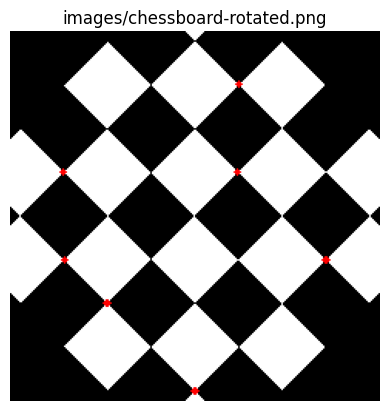

libpng warning: iCCP: known incorrect sRGB profile


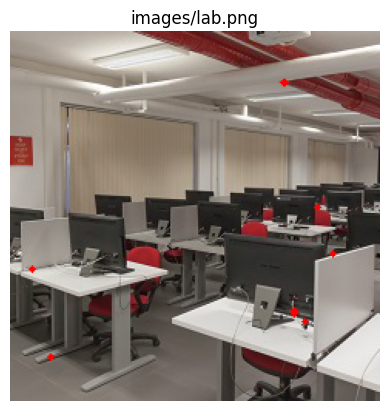

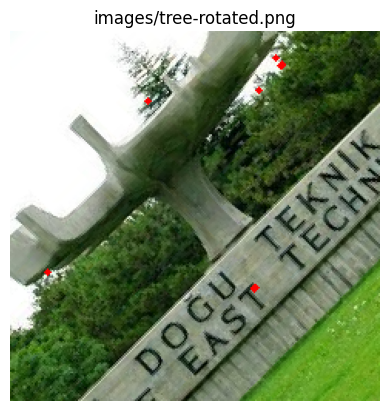

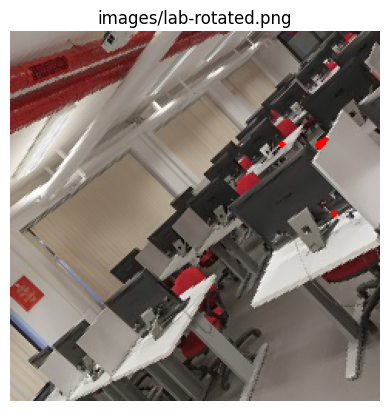

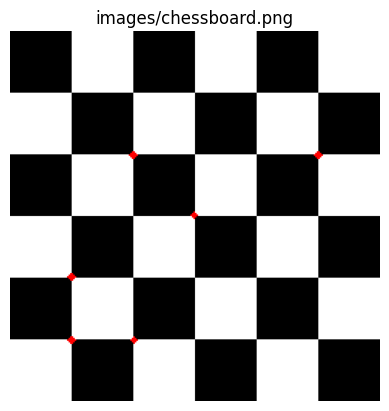

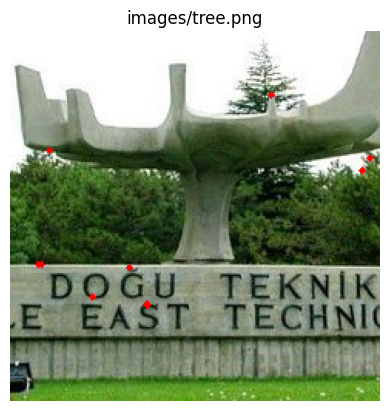

Average processing time for an image:  0.8743806680043539  seconds


In [14]:
def naiveUniformHarris(image, corner_number, w_d):
    #w_d : window dimension
    img = cv2.imread(image)
    result_img = img.copy()
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # this np.array will will keep energy level of each pixels
    energies_pixels = calculateWithGray(gray_image, w_d)

    # finding locations
    corner_locations = np.argpartition(-energies_pixels.flatten(), corner_number)[:corner_number]
    corner_locations = np.column_stack(np.unravel_index(corner_locations, energies_pixels.shape))

    # to ensure that the found vertices are not the same
    corner_locations = np.unique(corner_locations, axis=0)[:corner_number]
    
    # with this loop, iterating all corner indices and draw circle on that pixel in the result_img
    for index in corner_locations:
        cv2.circle(result_img, (index[1], index[0]), 2, (0, 0, 255), -1)
    return result_img

# the code below is for displaying images

cnt = 0 
# to count the number of images that processed

# you can change directory's name in here
path = 'images/'   
png_images = glob.glob(path + '*.png')
start_time = time.time()

for i, image in enumerate(png_images):
    cnt += 1
    result_img = naiveUniformHarris(image, 10, 3)
    # with changing second input you can get different number of corner in the image.

    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image)  
    plt.show()

end_time = time.time()
avg_time = (end_time - start_time) / cnt
print("Average processing time for an image: ", avg_time, " seconds")






In most of the pictures it is difficult to see 10 separate corners. Because non-maximum suppression is not done. Therefore, markings can be side by side. In addition, since corner detection is done by shifting the window, many point that are actually on the edge are detected as corner. The fact that we see these when looking at the 10 most likely ones is the disadvantage of not using non-maximum suppression. In addition, all of the detected corners are not actually corners, but points on edges. The reason for this is that we are not looking at directional change in this approach. We try to detect corners by sliding the window, but as a result we also get some points on the edges. It is also clearly seen that this approach is not rotation invariant.

## Naive Formula + Uniform Weighting

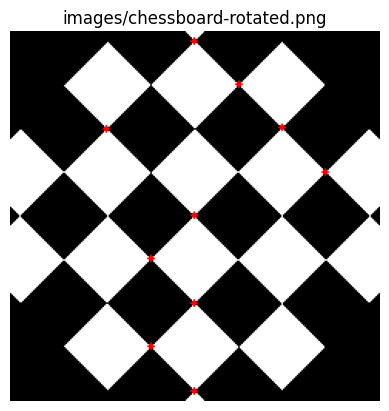

libpng warning: iCCP: known incorrect sRGB profile


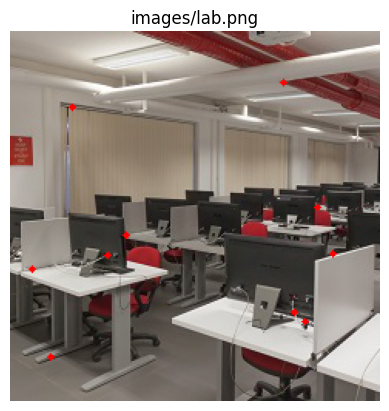

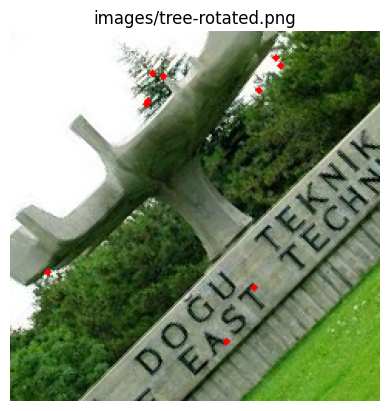

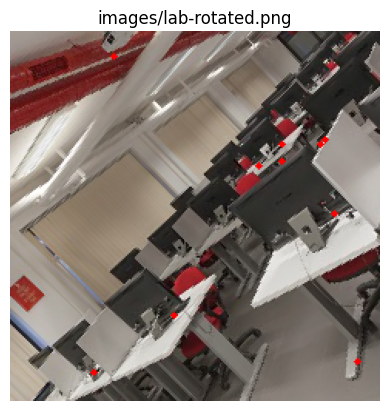

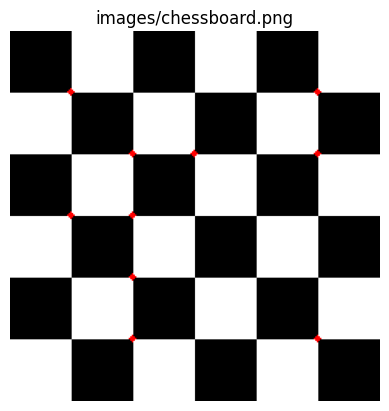

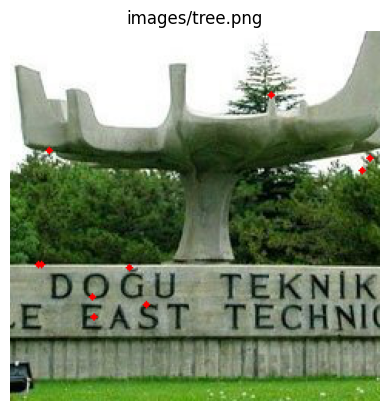

Average processing time for an image:  1.619600812594096  seconds


In [15]:

def naiveHarrisWithSuppression(image, corner_number, w_d):
    img = cv2.imread(image) 
    result_img = img.copy()
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    shape_0, shape_1 = img.shape[0], img.shape[1] 

    # this np.array will will keep energy level of each pixels
    energies_pixels = calculateWithGray(gray_image, w_d)

    # it will be sent to the function, non-max suppression will be done and it will return
    energies_pixels = nonMaxSuppression(energies_pixels, shape_0, shape_1)

    # finding locations
    corner_locations = np.argpartition(-energies_pixels.flatten(), corner_number)[:corner_number]
    corner_locations = np.column_stack(np.unravel_index(corner_locations, energies_pixels.shape))

    # to ensure that the found vertices are not the same
    corner_locations = np.unique(corner_locations, axis=0)[:corner_number]
    

    # with this loop, iterating all corner indices and draw circle on that pixel in the result_img
    for index in corner_locations:
        cv2.circle(result_img, (index[1], index[0]), 2, (0, 0, 255), -1)
    return result_img
    
# the code below is for displaying images

cnt = 0 
# to count image number that processed

# you can change directory's name in here
path = 'images/'   
png_images = glob.glob(path + '*.png')
start_time = time.time()

for i, image in enumerate(png_images):
    cnt += 1
    result_img = naiveHarrisWithSuppression(image, 10, 3)
    # by changing second input you can get different number of corner in the image.

    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)) 
    plt.axis('off')
    plt.title(image)  
    plt.show()

end_time = time.time()
avg_time = (end_time - start_time) / cnt
print("Average processing time for an image: ", avg_time, " seconds")

Write the discussion part in this Markdown block.

In addition to our previous approach, detection is now made more clearly thanks to non-maximum suppression. There are 10 separate corners. Some of them are very close, but the reason for this closeness is that my non-maximum suppression function only prevents them from being next to each other, there may be a pixel between them. We do not have corners that are next to each other. New vertices were detected in addition to the vertices detected in our previous approach. The disadvantage of this approach remains that the edge-corner separation is not smooth. It is also clearly seen that this approach is not rotation invariant.

## Taylor's Approximation + Uniform Weighting

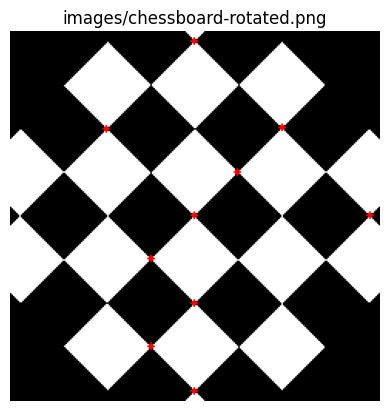

libpng warning: iCCP: known incorrect sRGB profile


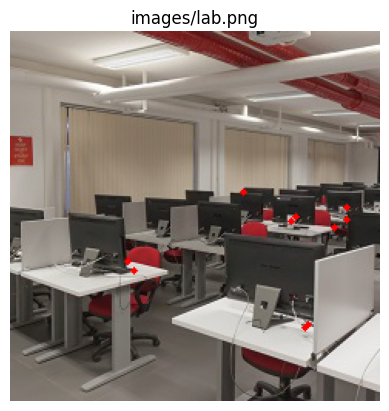

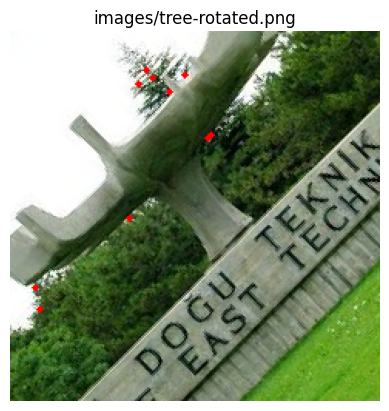

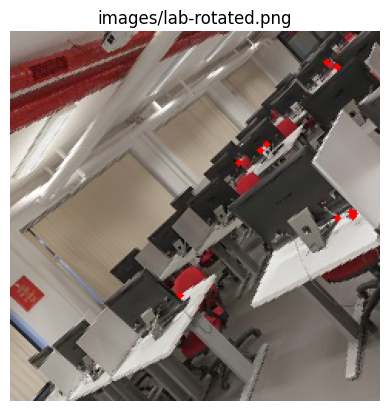

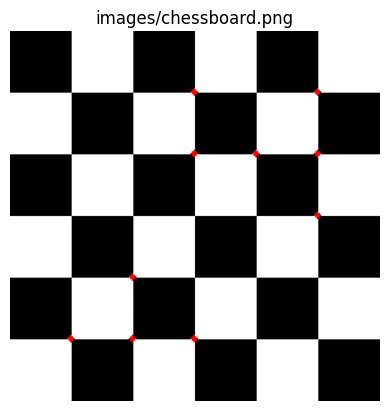

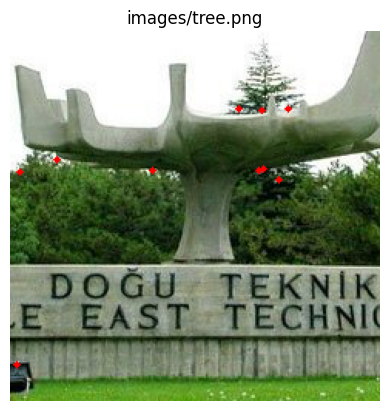

Average processing time for an image:  2.3751983642578125  seconds


In [16]:

def taylorHarris(img, corner_number, w_d):
    # w_d -> window dimension, if wanted: 3x3, w_d should be 3
    img = cv2.imread(image) 
    result_img = img.copy()
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    shape_0, shape_1 = gray_image.shape[0], gray_image.shape[1]
    half = w_d // 2

    Ix, Iy = np.gradient(gray_image)
    # we need gradient on x and y axis

    Ix2 = Ix * Ix
    Iy2 = Iy*Iy
    Ixy = Ix * Iy 
    # for matrix multiplications, firstly I used np.matmul but gave very incorrect corner result
    
    detection_array = np.zeros_like(gray_image, dtype=np.float64)
    max_eigenvals = np.zeros_like(gray_image, dtype=np.float64)
    # initating two np.array for keep min and max eigenvalues of that pixel location

    # iterating over all pixels
    # iterations are 1 to height and width -half because to prevent the w_d window from exceeding the image limit
    for i in range(half, shape_0 - half): 
        for j in range(half, shape_1 - half): 
            # to calculate the H, I calculate will calculate the sum of Ix2, Iy2, Ixy on that window
            win_Ix2 = Ix2[i - half:i + half+1, j - half:j + half+1]
            win_Iy2 = Iy2[i - half:i + half+1, j - half:j + half+1]
            win_Ixy = Ixy[i - half:i + half+1, j - half:j + half+1]

            H = np.array([[np.sum(win_Ix2), np.sum(win_Ixy)], [np.sum(win_Ixy), np.sum(win_Iy2)]])
            # H is 2x2 matrix consists of sum of grandients on that window
            
            eigenvalues = np.linalg.eigvals(H)
            min_eigenvalue = np.min(eigenvalues)
            max_eigenvalue = np.max(eigenvalues)   
            # algorithm need large min_eigenvalue. if it is larger, the probability that being corner of that pixel is higher.
            detection_array[i][j] = np.abs(min_eigenvalue)   
            max_eigenvals[i][j] = np.abs(max_eigenvalue)
            
    # if all min_eigenvalues are equal to zero, we can only detect edges
    # therefore we continue our process with max_eigenvalues and process them
    if np.max(detection_array)==0:
        detection_array = max_eigenvals

    # it will be sent to the function, non-max suppression will be done and it will return
    detection_array = nonMaxSuppression(detection_array, shape_0, shape_1)

    # finding locations
    corner_locations = np.argpartition(-detection_array.flatten(), corner_number)[:corner_number]
    corner_locations = np.column_stack(np.unravel_index(corner_locations, detection_array.shape))

    # to ensure that the found vertices are not the same
    corner_locations = np.unique(corner_locations, axis=0)[:corner_number]

    # with this loop, iterating all corner indices and draw circle on that pixel in the result_img
    for index in corner_locations:
        cv2.circle(result_img, (index[1], index[0]), 2, (0, 0, 255), -1)
    return result_img
    

# the code below is for displaying images

cnt = 0 

# you can change directory's name in here
path = 'images/'   
png_images = glob.glob(path + '*.png')
start_time = time.time()

for i, image in enumerate(png_images):
    cnt += 1
    result_img = taylorHarris(image, 10, 3)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image)  
    plt.show()

end_time = time.time()
avg_time = (end_time - start_time) / cnt
print("Average processing time for an image: ", avg_time, " seconds")

    
    


Write the discussion part in this Markdown block.

In my own experiments, I saw more clearly that this approach was successful when I increased the number of corners. By looking specifically at lab.png, we can see that it detects changes in a narrow area well. For this reason, it began to detect corners in the far parts of the photo more strongly. Since the change in corner structures in remote areas occurs in a narrower area and the window I control is 3x3, it is natural for it to detect changes in narrow areas. In general, details can now be captured more successfully by including aspects of change. Additionally, I did not observe it as completely rotation invariant, but especially when I increased the number of detected vertices and tried it, I can say that although it is not completely rotation invariant in the top-10 approach, it is close.

## Fast Implementation + Uniform Weighting

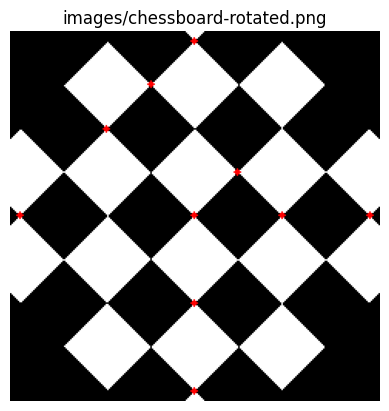

libpng warning: iCCP: known incorrect sRGB profile


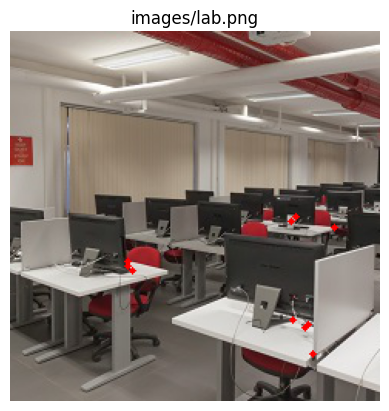

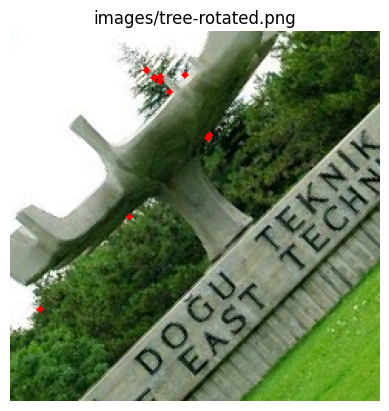

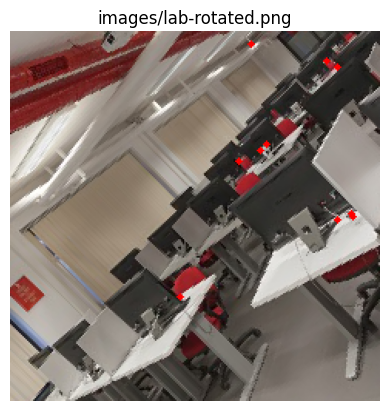

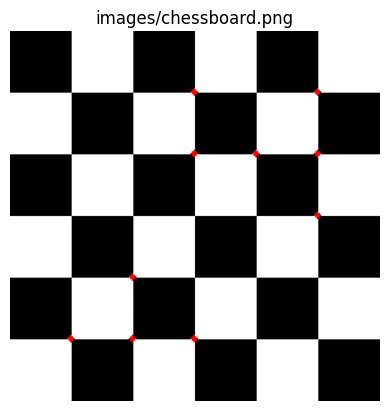

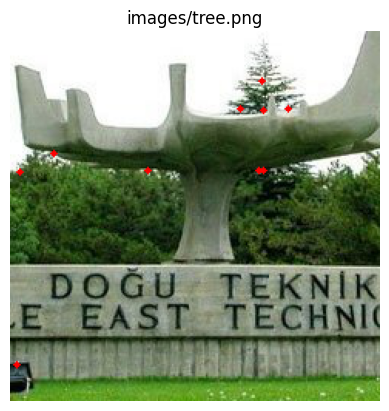

Average processing time for an image:  1.7347429990768433  seconds


In [17]:

def fastUniformHarris(img, corner_number, w_d):
    # w_d -> window dimension, i.e if wanted: 3x3, w_d should be 3
    img = cv2.imread(image) 
    result_img = img.copy()
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    shape_0, shape_1 = gray_image.shape[0], gray_image.shape[1]
    half = w_d//2

    Ix, Iy = np.gradient(gray_image)
    # we need gradient on x and y axis

    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy 

    strengths_pixels = np.zeros_like(gray_image, dtype=np.float64)

    # iterating over all pixels
    # iterations are 1 to height and width -half because to prevent the w_d window from exceeding the image limit
    for i in range(half, shape_0 - half): 
        for j in range(half, shape_1 - half): 
            # to calculate the H, I calculate will calculate the sum of Ix2, Iy2, Ixy on that window
            window_Ix = Ix2[i - half:i + half+1, j - half:j + half+1]
            window_Iy = Iy2[i - half:i + half+1, j - half:j + half+1]
            window_Ixy = Ixy[i - half:i + half+1, j - half:j + half+1]

            M = np.array([[np.sum(window_Ix), np.sum(window_Ixy)], [np.sum(window_Ixy), np.sum(window_Iy)]])
            # M is 2x2 matrix consists of sum of grandients on that window

            trace = np.matrix.trace(M)
            determinant = np.linalg.det(M)
            # calculating trace and determinant of M

            Q = determinant - 0.05 * (trace ** 2)  # Q is corner response, corner strength
            if Q>0:
                strengths_pixels[i][j] = Q
                       
    # it will be sent to the function, non-max suppression will be done and it will return
    strengths_pixels = nonMaxSuppression(strengths_pixels, shape_0, shape_1)

    # finding locations
    corner_locations = np.argpartition(-strengths_pixels.flatten(), corner_number)[:corner_number]
    corner_locations = np.column_stack(np.unravel_index(corner_locations, strengths_pixels.shape))

    # to ensure that the found vertices are not the same
    corner_locations = np.unique(corner_locations, axis=0)[:corner_number]

    # with this loop, iterating all corner indices and draw circle on that pixel in the result_img
    for index in corner_locations:
        cv2.circle(result_img, (index[1], index[0]), 2, (0, 0, 255), -1)

    return result_img
    
# the code below is for displaying images

cnt = 0 

# you can change directory's name in here
path = 'images/'   
png_images = glob.glob(path + '*.png')
start_time = time.time()

for i, image in enumerate(png_images):
    cnt += 1
    result_img = fastUniformHarris(image, 10, 3)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image)  
    plt.show()

end_time = time.time()
avg_time = (end_time - start_time) / cnt
print("Average processing time for an image: ", avg_time, " seconds")

Write the discussion part in this Markdown block.

Corners almost identical to those obtained with the Taylor approach were detected. This is not a surprising result, we do not perform the intermediate steps by estimating the constant k, which we do in the Taylor approach, and this speeds up the process. It can be seen from the average time that results are obtained faster. Since we see almost the same corners as the Taylor approach, we can say that our algorithm does not lose its detection ability to a significant extent with the "fast implementation" and therefore this approach is efficient because it increases the working speed. Regarding rotation, I cannot say that rotation is completely invariant, but there are sufficient corners. Therefore, rotation can be said to be close to being invariant to rotation.

## Fast Implementation + Circular Weighting

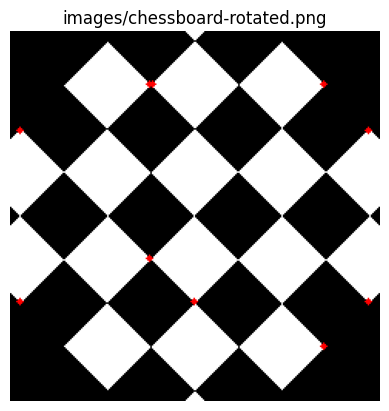

libpng warning: iCCP: known incorrect sRGB profile


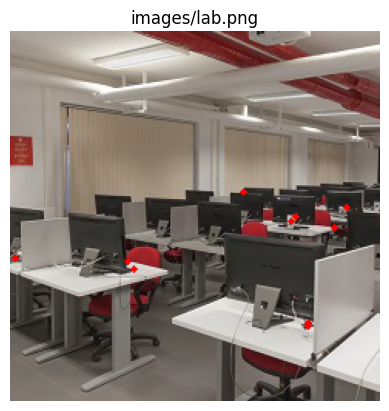

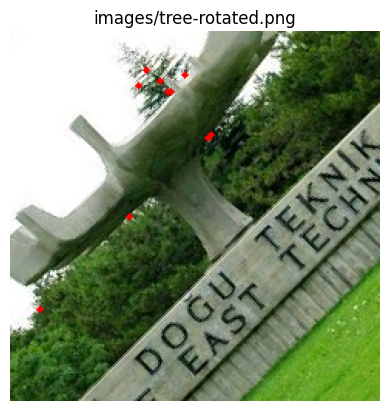

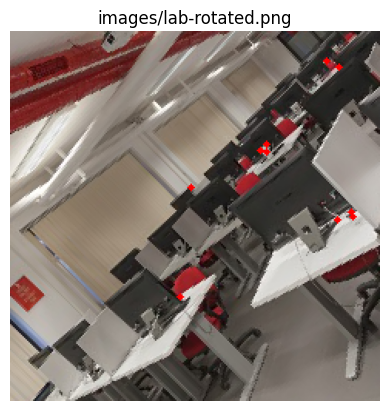

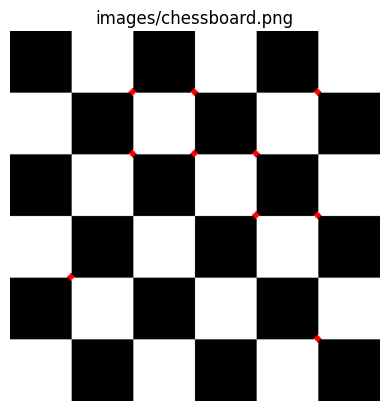

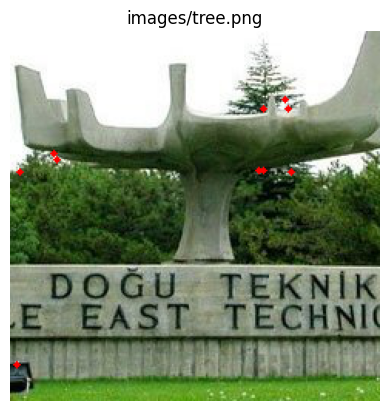

Average processing time for an image:  1.9951594670613606  seconds


In [18]:
# Write your code here
def fastCircularHarris(img, corner_number, w_d):
    # w_d -> window dimension, i.e if wanted: 3x3, w_d should be 3
    img = cv2.imread(image) 
    result_img = img.copy()
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    shape_0, shape_1 = gray_image.shape[0], gray_image.shape[1]
    half_r = w_d//2

    Ix, Iy = np.gradient(gray_image)
    # we need gradient on x and y axis

    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy 

    strengths_pixels = np.zeros_like(gray_image, dtype=np.float64)
    circular_filter = np.ones((w_d, w_d))

    for i in range(w_d):
        for j in range(w_d):
            if np.square(i-half_r) + np.square(j-half_r) > np.square(half_r):
                circular_filter[i][j] = 0

    # iterating over all pixels
    # iterations are 1 to height and width -half because to prevent the w_d window from exceeding the image limit
    for i in range(half_r, shape_0 - half_r): 
        for j in range(half_r, shape_1 - half_r): 
            # to calculate the H, I calculate will calculate the sum of Ix2, Iy2, Ixy on that window
            window_Ix2 = Ix2[i - half_r:i + half_r+1, j - half_r:j + half_r+1] * circular_filter
            window_Iy2 = Iy2[i - half_r:i + half_r+1, j - half_r:j + half_r+1] * circular_filter
            window_Ixy = Ixy[i - half_r:i + half_r+1, j - half_r:j + half_r+1] * circular_filter

            M = np.array([[np.sum(window_Ix2), np.sum(window_Ixy)], [np.sum(window_Ixy), np.sum(window_Iy2)]])
            trace = np.matrix.trace(M)
            determinant = np.linalg.det(M)

            Q = determinant - 0.05 * (trace ** 2)  #0.05 değişebilir!!
            strengths_pixels[i][j] = Q
                 
    # it will be sent to the function, non-max suppression will be done and it will return
    strengths_pixels = nonMaxSuppression(strengths_pixels, shape_0, shape_1)

    # finding locations
    corner_locations = np.argpartition(-strengths_pixels.flatten(), corner_number)[:corner_number]
    corner_locations = np.column_stack(np.unravel_index(corner_locations, strengths_pixels.shape))

    # to ensure that the found vertices are not the same
    corner_locations = np.unique(corner_locations, axis=0)[:corner_number]

    # with this loop, iterating all corner indices and draw circle on that pixel in the result_img
    for index in corner_locations:

        cv2.circle(result_img, (index[1], index[0]), 2, (0, 0, 255), -1)
    return result_img
    
# the code below is for displaying images

cnt = 0 

# you can change directory's name in here
path = 'images/'   
png_images = glob.glob(path + '*.png')
start_time = time.time()

for i, image in enumerate(png_images):
    cnt += 1
    result_img = fastCircularHarris(image, 10, 3)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image)  
    plt.show()

end_time = time.time()
avg_time = (end_time - start_time) / cnt
print("Average processing time for an image: ", avg_time, " seconds")

Between circular weighting and uniform weighting, I expected the correct detection rate of the corners to increase slightly, as the pixels close to center became a little more important, thanks to the circular filter. This happened to a small extent, but there was no significant change. As can be seen from chessboard.png, thanks to the circular weight, we detected points that were actually corners, but which we could not easily detect before due to the weight method. It can be said that the accuracy of corner detection has increased slightly as the pixels in the center and close to the center have become more important.

## Fast Implementation + Gaussian Weighting

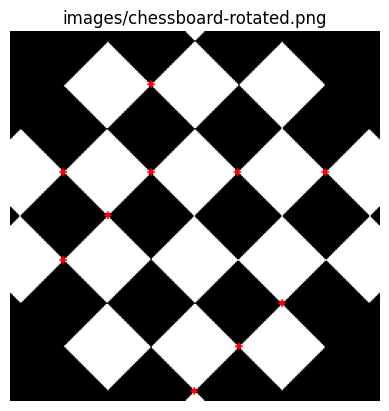

libpng warning: iCCP: known incorrect sRGB profile


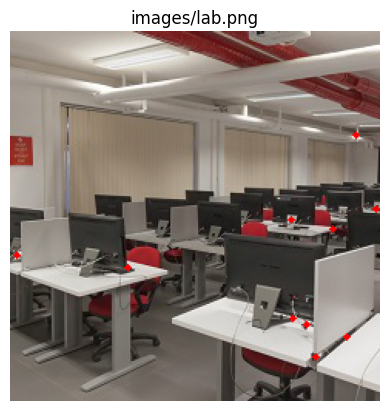

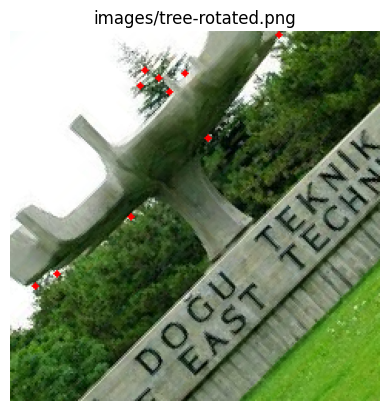

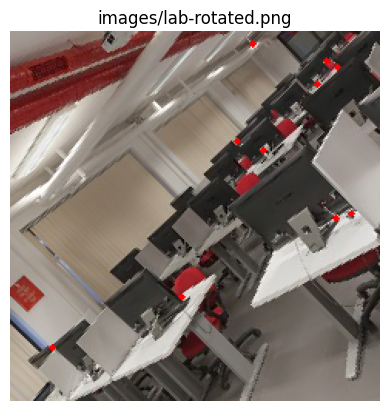

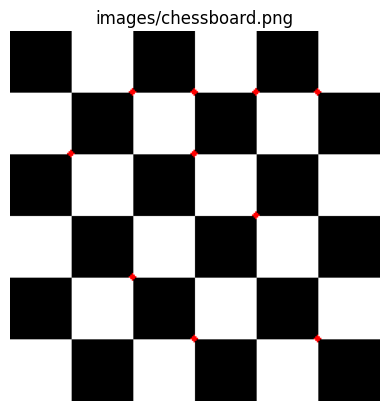

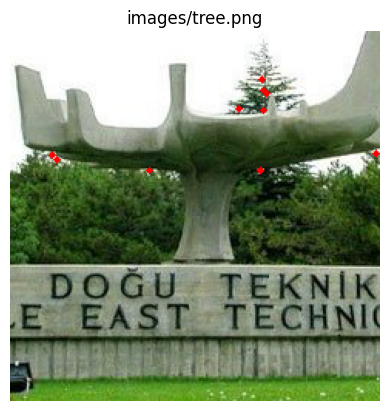

Average processing time for an image:  1.8579399983088176  seconds


In [19]:
def fastGaussianHarris(img, corner_number, w_d):

    # w_d -> window dimension, i.e if wanted: 3x3, w_d should be 3
    img = cv2.imread(image) 
    result_img = img.copy()
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    shape_0, shape_1 = gray_image.shape[0], gray_image.shape[1]
    half = w_d//2

    Ix, Iy = np.gradient(gray_image)
    # we need gradient on x and y axis

    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy 

    strengths_pixels = np.zeros_like(gray_image, dtype=np.float64)
    
    Ix2 = cv2.GaussianBlur(Ix*Ix,(w_d, w_d), 3)
    Iy2 = cv2.GaussianBlur(Iy*Iy,(w_d, w_d), 3)
    Ixy = cv2.GaussianBlur(Ix*Iy,(w_d, w_d), 3)


    # iterating over all pixels
    # iterations are 1 to height and width -half because to prevent the w_d window from exceeding the image limit
    for i in range(half, shape_0 - half): 
        for j in range(half, shape_1 - half): 
            # to calculate the H, I calculate will calculate the sum of Ix2, Iy2, Ixy on that window
            window_Ix = Ix2[i - half:i + half+1, j - half:j + half+1]
            window_Iy = Iy2[i - half:i + half+1, j - half:j + half+1]
            window_Ixy = Ixy[i - half:i + half+1, j - half:j + half+1]
            
            M = np.array([[np.sum(window_Ix), np.sum(window_Ixy)], [np.sum(window_Ixy), np.sum(window_Iy)]])
            trace = np.matrix.trace(M)
            determinant = np.linalg.det(M)

            Q = determinant - 0.05 * (trace ** 2)  #0.05 değişebilir!!
            strengths_pixels[i][j] = Q
                
    # it will be sent to the function, non-max suppression will be done and it will return
    strengths_pixels = nonMaxSuppression(strengths_pixels, shape_0, shape_1)

    # finding locations
    corner_locations = np.argpartition(-strengths_pixels.flatten(), corner_number)[:corner_number]
    corner_locations = np.column_stack(np.unravel_index(corner_locations, strengths_pixels.shape))

    # to ensure that the found vertices are not the same
    corner_locations = np.unique(corner_locations, axis=0)[:corner_number]

    # with this loop, iterating all corner indices and draw circle on that pixel in the result_img
    for index in corner_locations:

        cv2.circle(result_img, (index[1], index[0]), 2, (0, 0, 255), -1)
    return result_img

# the code below is for displaying images

cnt = 0 

# you can change directory's name in here
path = 'images/'   
png_images = glob.glob(path + '*.png')
start_time = time.time()

for i, image in enumerate(png_images):
    cnt += 1
    result_img = fastGaussianHarris(image, 10, 5)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image)  
    plt.show()

end_time = time.time()
avg_time = (end_time - start_time) / cnt
print("Average processing time for an image: ", avg_time, " seconds")

Gaussian weight, which is similar to circular weight because it gives more weight to the points in the center and close to the center, gave a good result. Some detected corners are the same with circular weight. With the Gaussian filter, we make the pixels in the center more important, just like the circular filter, so the success rate increases. In fact, since we change the weights according to the distance from the center, the ones in the center become more important compared to circular weight. We were not affected by noise much due to our small filter size, but if we use a larger filter, we will start to be negatively affected by noise around a point.

## Fast Implementation + Gaussian Weighting + RGB Split

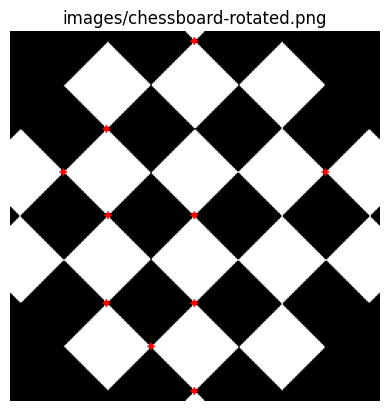

libpng warning: iCCP: known incorrect sRGB profile


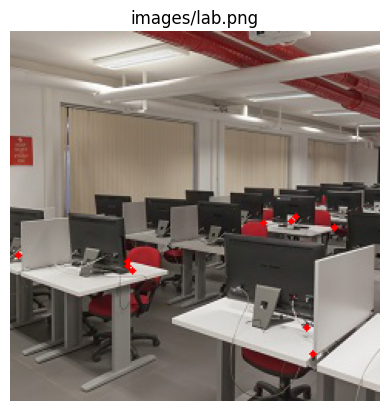

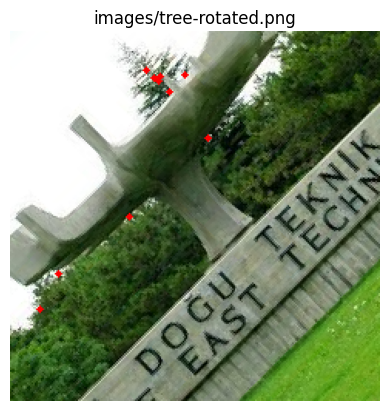

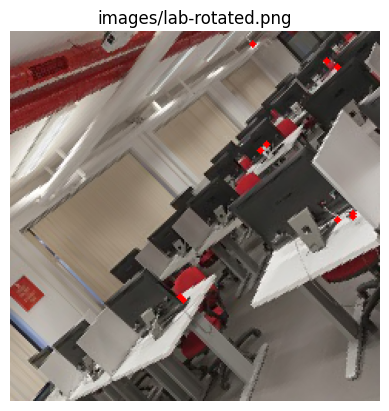

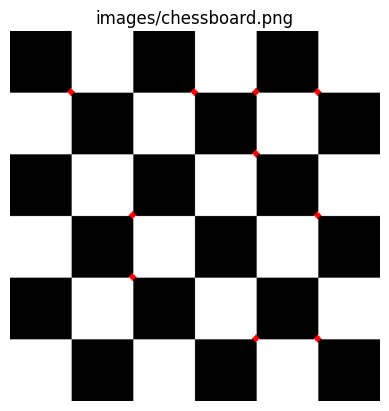

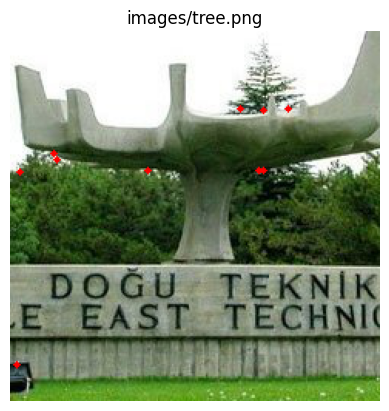

Average processing time for an image:  3.9510867993036904  seconds


In [20]:
def eachChannel(img, corner_number, w_d):

    shape_0, shape_1 = img.shape[0], img.shape[1]

    half = w_d//2
    Ix, Iy = np.gradient(img)
    # we need gradient on x and y axis

    Ix2 = cv2.GaussianBlur(Ix*Ix,(w_d, w_d), 0)
    Iy2 = cv2.GaussianBlur(Iy*Iy,(w_d, w_d), 0)
    Ixy = cv2.GaussianBlur(Ix*Iy,(w_d, w_d), 0)

    strengths_pixels = np.zeros_like(img, dtype=np.float64)

    # iterating over all pixels
    # iterations are 1 to height and width -half because to prevent the w_d window from exceeding the image limit
    for i in range(half, shape_0 - half): 
        for j in range(half, shape_1 - half): 
            # to calculate the H, I calculate will calculate the sum of Ix2, Iy2, Ixy on that window
            window_Ix = Ix2[i - half:i + half+1, j - half:j + half+1]
            window_Iy = Iy2[i - half:i + half+1, j - half:j + half+1]
            window_Ixy = Ixy[i - half:i + half+1, j - half:j + half+1]
            
            M = np.array([[np.sum(window_Ix), np.sum(window_Ixy)], [np.sum(window_Ixy), np.sum(window_Iy)]])
            trace = np.matrix.trace(M)
            determinant = np.linalg.det(M)

            Q = determinant - 0.05 * (trace ** 2)  
            strengths_pixels[i][j] = Q

    return strengths_pixels
    

def fastGaussianRGBSplitHarris1(img, corner_number, w_d):
    # w_d -> window dimension, i.e if wanted: 3x3, w_d should be 3
    img = cv2.imread(image) 
    result_img = img.copy()

    blue_img, green_img, red_img = cv2.split(img)

    shape_0, shape_1 = img.shape[0], img.shape[1]

    half = w_d//2

    strengths_pixels_blue = eachChannel(blue_img, corner_number, w_d)
    strengths_pixels_green = eachChannel(green_img, corner_number, w_d)
    strengths_pixels_red = eachChannel(red_img, corner_number, w_d)

    strengths_pixels = np.add(strengths_pixels_blue, strengths_pixels_green, strengths_pixels_red)

    # it will be sent to the function, non-max suppression will be done and it will return
    strengths_pixels = nonMaxSuppression(strengths_pixels, shape_0, shape_1)

    # finding locations
    corner_locations = np.argpartition(-strengths_pixels.flatten(), corner_number)[:corner_number]
    corner_locations = np.column_stack(np.unravel_index(corner_locations, strengths_pixels.shape))

    # to ensure that the found vertices are not the same
    corner_locations = np.unique(corner_locations, axis=0)[:corner_number]

    # with this loop, iterating all corner indices and draw circle on that pixel in the result_img
    for index in corner_locations:

        cv2.circle(result_img, (index[1], index[0]), 2, (0, 0, 255), -1)
    return result_img


def fastGaussianRGBSplitHarris2(img, corner_number, w_d):
    # w_d -> window dimension, i.e if wanted: 3x3, w_d should be 3
    img = cv2.imread(image) 
    result_img = img.copy()

    blue_img, green_img, red_img = cv2.split(img)

    shape_0, shape_1 = img.shape[0], img.shape[1]

    half = w_d // 2

    strengths_pixels_blue = eachChannel(blue_img, corner_number, w_d)
    strengths_pixels_green = eachChannel(green_img, corner_number, w_d)
    strengths_pixels_red = eachChannel(red_img, corner_number, w_d)

    strengths_pixels_blue = nonMaxSuppression(strengths_pixels_blue, shape_0, shape_1)
    strengths_pixels_green = nonMaxSuppression(strengths_pixels_green, shape_0, shape_1)
    strengths_pixels_red = nonMaxSuppression(strengths_pixels_red, shape_0, shape_1)

    strengths_pixels = np.add(strengths_pixels_blue, strengths_pixels_green, strengths_pixels_red)

    # finding locations
    corner_locations = np.argpartition(-strengths_pixels.flatten(), corner_number)[:corner_number]
    corner_locations = np.column_stack(np.unravel_index(corner_locations, strengths_pixels.shape))

    # to ensure that the found vertices are not the same
    corner_locations = np.unique(corner_locations, axis=0)[:corner_number]

    # with this loop, iterating all corner indices and draw circle on that pixel in the result_img
    for index in corner_locations:

        cv2.circle(result_img, (index[1], index[0]), 2, (0, 0, 255), -1)
    return result_img
# the code below is for displaying images

cnt = 0 

# you can change directory's name in here
path = 'images/'   
png_images = glob.glob(path + '*.png')
start_time = time.time()

for i, image in enumerate(png_images):
    cnt += 1
    result_img = fastGaussianRGBSplitHarris1(image, 10, 3)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image)  
    plt.show()

end_time = time.time()
avg_time = (end_time - start_time) / cnt
print("Average processing time for an image: ", avg_time, " seconds")


Since I couldn't fully understand which approach I should use, I wrote 2 functions. You can take the first one for evaluation, I have already run it in the examples.

It works significantly slower than all other approaches. Because we actually lose a lot of time because we do the same process for all color channels. I did not observe any meaningful difference in the detected corners due to RGB split. It's almost the same as in my gray-scale calculations. Despite the performance loss it caused, it did not provide any improvement in detection.


# Conclusion

I think fast implementation is better than naive implementation and Taylor approach. Since we do not look at direction-based changes in the naive implementation, we also detect points on the edge, which reduces the accuracy rate. The Taylor approach gives almost the same result as the fast implementation, but it is slower. Therefore, I think fast implementation is better because it has sufficient accuracy and works fast. As for weighting, I think circular and Gaussian are better than uniform weighting because our accuracy rate increases as we weight the points in the center or close to the center. Between circular weighting and Gaussian weighting, in my opinion, Gaussian comes to the fore because I think the success increases due to the strengthening of the pixels close to the center.
I could not see any difference between RGB split and grayscale application.  Before writing the RGB split code, I assumed that it would work more successfully, but this did not happen. I may have made a mistake during implementation. According to my logic, it should be more successful. However, based on the results I obtained, I think that gray-scale is better because RGB split slows down the process a lot.

Therefore, according to my implementations the best scenario in my opinion is: Fast implementation + Gaussian